In [1]:
import pyspark
import matplotlib.pyplot as plt

from pyspark import SparkContext, SQLContext
sc = pyspark.SparkContext('local[*]')
sqlc = SQLContext(sc)

In [2]:
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.types import StringType,FloatType, StructType, StructField, IntegerType
from pyspark.sql import functions as F, Window
from pyspark.sql.functions import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import pandas as pd

In [6]:
predictions_train=sqlc.read.json('./data/ur_forks_stars_rec.json')


In [7]:
predictions_train.count()

24225

In [8]:
test_set=sqlc.read.csv('./data/forks_stars_sample_test.csv')


In [9]:
test_set = test_set.withColumnRenamed("_c0", "user_id")
test_set = test_set.withColumnRenamed("_c1", "repo_id")
test_set = test_set.withColumnRenamed("_c2", "created_at")
test_set= test_set.withColumnRenamed("_c3","event")


In [10]:
test_set.show()

+--------+--------+--------------------+-----+---+---+
| user_id| repo_id|          created_at|event|_c4|_c5|
+--------+--------+--------------------+-----+---+---+
| 1257187|72794607|2017-08-24 09:23:...| star| 10| 10|
| 2530699|72275307|2017-08-17 11:13:...| star| 10| 10|
| 6343011|54590580|2017-08-18 14:51:...| star| 10| 10|
|   87179|70572848|2017-07-30 17:56:...| star| 10| 10|
| 9468214|71762911|2017-08-21 06:31:...| star| 10| 10|
|10524124|69294657|2017-08-30 15:42:...| star| 11| 11|
|11605903|67579486|2017-07-18 14:57:...| fork| 11| 11|
| 1595832|67486455|2017-08-03 13:29:...| star| 11| 11|
| 1659818|70597953|2017-08-02 08:01:...| star| 11| 11|
| 1741103|71963983|2017-08-22 18:59:...| star| 11| 11|
| 2777053|55936096|2017-08-28 01:59:...| fork| 11| 11|
|33505601|68233216|2017-07-20 20:45:...| fork| 11| 11|
| 8076229|72495158|2017-08-21 04:07:...| star| 11| 11|
| 8266172|55486950|2017-08-22 05:51:...| star| 11| 11|
| 1825531|72275307|2017-08-29 01:52:...| star| 12| 12|
| 3521304|

In [11]:
predictions_train.show()

+--------------------+--------+
|                 rec| user_id|
+--------------------+--------+
|[[55021487,0.0], ...|   82886|
|[[58288948,0.3136...|10115499|
|[[72558129,0.1713...| 1456072|
|[[55714841,0.5334...|12196708|
|[[68604188,2.6038...|36918139|
|[[64597237,0.5386...|  170409|
|[[61869903,0.6690...| 2809577|
|[[68945047,0.4587...| 3526598|
|[[56897739,0.9274...| 6072147|
|[[55774251,0.2186...| 3226446|
|[[69429719,0.1842...|   46291|
|[[57199168,0.4081...|  841352|
|[[64447990,0.5380...| 4878994|
|[[59371509,0.2022...|    1542|
|[[54500534,1.6585...|31803182|
|[[65400831,0.3684...| 5925988|
|[[68929881,0.5610...|11691229|
|[[57712080,0.2935...| 6835070|
|[[68086609,0.6160...|  166000|
|[[61242517,0.1019...| 1902994|
+--------------------+--------+
only showing top 20 rows



### Preparation of the prediction data set

In [12]:
predictions_train=predictions_train.withColumn('scores',explode('rec'))
predictions_train=predictions_train.withColumn('repo_id',predictions_train.scores['item'])\
                       .withColumn('score',predictions_train.scores['score'])

predictions_train=predictions_train.select('user_id','repo_id','score')


### For each user order repos by score

In [15]:
w=(Window.partitionBy('user_id').orderBy(col('score').desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow))
predictions_train=predictions_train.withColumn('reccomendations',F.count('user_id').over(w))

In [16]:
predictions_train.show()

+--------+--------+-------------------+---------------+
| user_id| repo_id|              score|reccomendations|
+--------+--------+-------------------+---------------+
|10013904|68785107|  1.570141077041626|              1|
|10013904|61798405|  1.183546781539917|              2|
|10013904|65481637|  1.144757866859436|              3|
|10013904|64535847| 1.1407822370529175|              4|
|10013904|64253797| 1.1407822370529175|              5|
|10013904|54768394|  1.117347240447998|              6|
|10013904|57507098|  1.117347240447998|              7|
|10013904|65200326|  1.117347240447998|              8|
|10013904|55310803| 1.1072978973388672|              9|
|10013904|55936096| 1.1072978973388672|             10|
|10013904|58632066| 1.1072978973388672|             11|
|10013904|56132918| 1.0467606782913208|             12|
|10013904|60254642| 1.0467606782913208|             13|
|10013904|67048455| 1.0467606782913208|             14|
|10013904|59517760| 1.0467606782913208|         

### Take scores>0

In [17]:
predictions_final=predictions_train.filter('score>0')

## How many forks in the test set are predicted from UR?

In [18]:
predictions_final=predictions_final.select(col('user_id').alias('p_user_id'),col('repo_id').alias('p_repo_id'),'score')

test_forks=test_set.filter(test_set.event=='fork')

test_join=test_forks.join(predictions_final,(test_forks.user_id==predictions_final.p_user_id)\
                   & (test_forks.repo_id==predictions_final.p_repo_id),'left')

In [19]:
test_join.filter('p_repo_id is not null').count()/test_forks.count()  

0.609072375127421

## Distribution of scores on the test set

In [20]:
test_scores=test_join.filter('p_repo_id is not null')

In [21]:
l=test_scores.select('score').rdd.map(lambda x: x.score).collect()

In [22]:
l_norm=(l-np.min(l))/(np.max(l)-np.min(l))

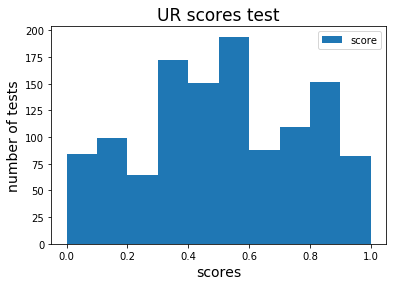

In [25]:
pd.DataFrame(l_norm,columns=['score']).plot.hist() #1 user has 14.000 stars
#fig.title('Distribution of stars by user')
plt.xlabel('scores', fontsize=14)
plt.ylabel('number of tests', fontsize=14)
plt.title('UR scores test', fontsize=17)

plt.savefig('ur_score_test.png')

In [26]:
sc.stop()